In [24]:
import pickle
import json
import os
import numpy as np
from bitsets import bitset
from matplotlib import pyplot as plt
import itertools
import networkx as nx
import metis
import random

In [25]:
n_clients = 10
task = 'synthetic_classification_cnum10_dist10_skew0.5_seed0'
folder = '../fedtask/{}/record/'.format(task)
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
DICT = dict()
files = os.listdir(folder)
files.sort(reverse=True)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
DICT['0' * n_clients] = np.zeros(101)
CLIENTS_BITSET = bitset('clients_bitset', tuple(range(n_clients)))
ideal = list()
for round_ in range(1, 101):
    tmp = list()
    for client in range(n_clients):
        result = 0.0
        rest_clients = [client_ for client_ in range(n_clients) if client_ != client]
        for i in range(0, len(rest_clients) + 1):
            a_i = 0.0
            count_i = 0
            for subset in itertools.combinations(rest_clients, i):
                if round_ == 1:
                    a_i += \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][round_] - \
                            DICT[CLIENTS_BITSET(subset).bits()][round_]
                        )
                else:
                    a_i += \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][round_] - \
                            DICT[CLIENTS_BITSET(subset).bits()][round_]
                        ) -  \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][round_ - 1] - \
                            DICT[CLIENTS_BITSET(subset).bits()][round_ - 1]
                        )
                count_i += 1
            a_i = a_i / count_i
            result += a_i
        result = result / len(range(n_clients))
        tmp.append(result)
    ideal.append(tmp)
ideal = np.array(ideal)

In [26]:
ideal.sum(axis=0)

array([0.06469306, 0.06192165, 0.06891276, 0.1246724 , 0.1002628 ,
       0.08686129, 0.09917838, 0.05139152, 0.05667293, 0.08654975])

In [27]:
approx = list()
for round_ in range(1, 101):
    with open(os.path.join('../SV_result', task, 'delta-exact-10', 'Round{}.npy'.format(round_)), 'rb') as f:
        approx.append(pickle.load(f).tolist())
approx = np.array(approx)

In [28]:
ideal.sum(axis=0), approx.sum(axis=0)

(array([0.06469306, 0.06192165, 0.06891276, 0.1246724 , 0.1002628 ,
        0.08686129, 0.09917838, 0.05139152, 0.05667293, 0.08654975]),
 array([0.0787733 , 0.09512539, 0.0813877 , 0.08337847, 0.08777152,
        0.08226719, 0.07380205, 0.06237802, 0.07202866, 0.08490208]))

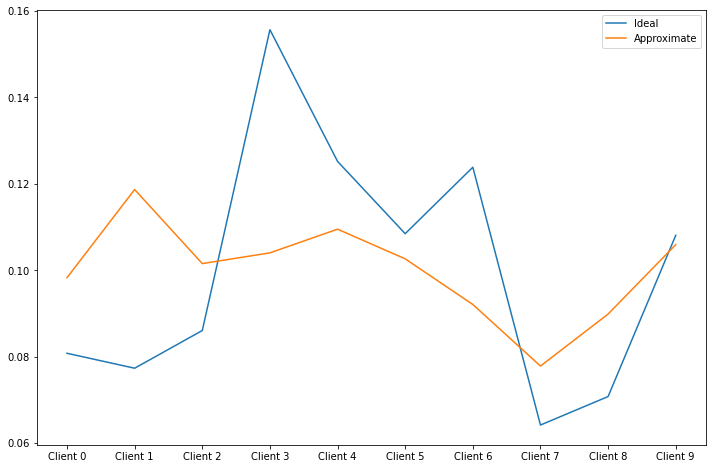

In [29]:
x = ['Client {}'.format(i) for i in range(n_clients)]
plt.figure(figsize=(12, 8))
plt.plot(x, ideal.sum(axis=0) / ideal.sum(), label='Ideal')
plt.plot(x, approx.sum(axis=0) / approx.sum(), label='Approximate')
plt.legend()
plt.show()

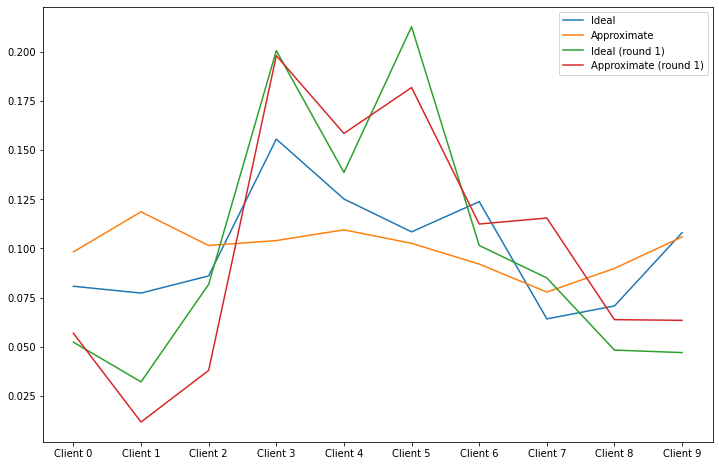

In [30]:
x = ['Client {}'.format(i) for i in range(n_clients)]
plt.figure(figsize=(12, 8))
plt.plot(x, ideal.sum(axis=0) / ideal.sum(), label='Ideal')
plt.plot(x, approx.sum(axis=0) / approx.sum(), label='Approximate')
plt.plot(x, ideal[0] / ideal[0].sum(), label='Ideal (round 1)')
plt.plot(x, approx[0] / approx[0].sum(), label='Approximate (round 1)')
plt.legend()
plt.show()

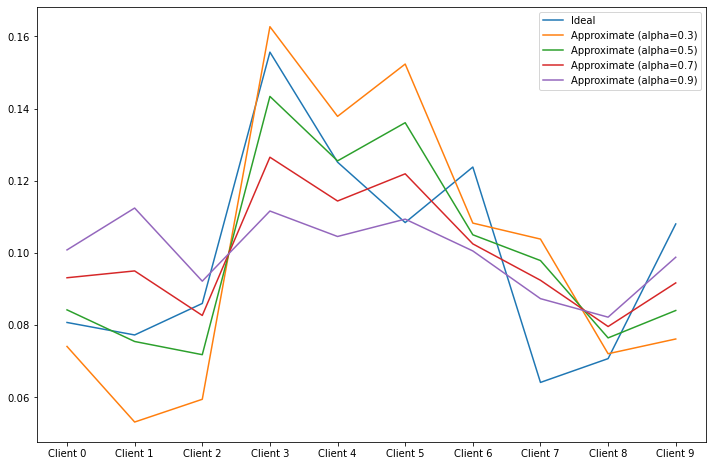

In [48]:
result_dict = dict()
for alpha in [0.3, 0.5, 0.7, 0.9]:
    result = np.zeros(approx.shape[1])
    moment = np.zeros(approx.shape[1])
    for index in range(approx.shape[0]):
        if index == 0:
            moment = approx[index]
        else:
            moment = (alpha * (approx.shape[0] - index) / approx.shape[0]) * approx[index] + (1 - (alpha * (approx.shape[0] - index) / approx.shape[0])) * moment
        result += moment
    result_dict[alpha] = result
x = ['Client {}'.format(i) for i in range(n_clients)]
plt.figure(figsize=(12, 8))
plt.plot(x, ideal.sum(axis=0) / ideal.sum(), label='Ideal')
for alpha, result in result_dict.items():
    plt.plot(x, result / result.sum(), label='Approximate (alpha={})'.format(alpha))
plt.legend()
plt.show()

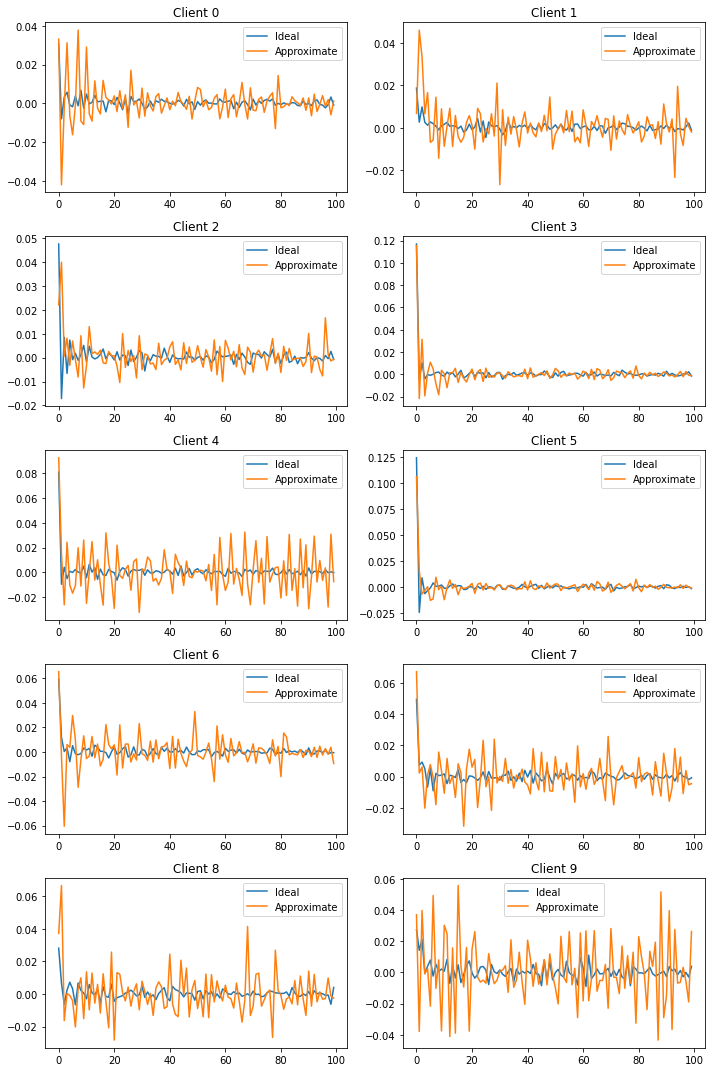

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(10)
for i in range(n_clients):
    ax[i // 2, i % 2].plot(ideal[:, i], label='Ideal')
    ax[i // 2, i % 2].plot(approx[:, i], label='Approximate')
    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title('Client {}'.format(i))
fig.tight_layout()
plt.show()

# Each round

In [33]:
# def utility_function(round_, client_indices_):
#     if round_ == 1:
#         return DICT[CLIENTS_BITSET(client_indices_).bits()][round_]
#     return DICT[CLIENTS_BITSET(client_indices_).bits()][round_] - DICT[CLIENTS_BITSET(client_indices_).bits()][round_ - 1]

In [34]:
# def sub_utility_function(round_, partition_indices_, client_indices_):
#     intersection = list(set(partition_indices_).intersection(set(client_indices_)))
#     return utility_function(round_, intersection)

In [35]:
# def shapley_value(round_, client_index_, client_indices_):
#     if client_index_ not in client_indices_:
#         return 0.0
#     result = 0.0
#     rest_client_indexes = [index for index in client_indices_ if index != client_index_]
#     num_rest = len(rest_client_indexes)
#     for i in range(0, num_rest + 1):
#         a_i = 0.0
#         count_i = 0
#         for subset in itertools.combinations(rest_client_indexes, i):
#             a_i += utility_function(round_, set(subset).union({client_index_})) - utility_function(round_, subset)
#             count_i += 1
#         a_i = a_i / count_i
#         result += a_i
#     result = result / len(client_indices_)
#     return result

In [36]:
# with open(os.path.join('../fedtask', task, 'data.json'), 'r') as f:
#     len_test_data = len(json.load(f)['dtest']['y'])
# len_test_data

In [37]:
# const_lambda_SV = list()
# optimal_lambda_SV = dict()
# for round_ in range(1, 101):
#     num_partitions = 2
#     edges = list()
#     for u in range(n_clients):
#         for v in range(n_clients):
#             if u >= v:
#                 continue
#             w = utility_function(round_, [u]) + utility_function(round_, [v]) - utility_function(round_, [u, v])
#             w *= len_test_data
#             w = int(np.round(w))
#             edges.append((u, v, w))
#     rnd_graph = nx.Graph()
#     rnd_graph.add_weighted_edges_from(edges)
#     rnd_graph.graph['edge_weight_attr'] = 'weight'
#     rnd_all_nodes = np.array(rnd_graph.nodes)

#     # Partition graph
#     rnd_partitions = list()
#     cutcost, partitions = metis.part_graph(rnd_graph, nparts=num_partitions, recursive=True)
#     for partition_index in np.unique(partitions):
#         nodes_indexes = np.where(partitions == partition_index)[0]
#         rnd_partitions.append(rnd_all_nodes[nodes_indexes])
        
#     # Const lambda
#     round_SV = np.zeros(n_clients)
#     for m in range(num_partitions):
#         for client_index in range(n_clients):
#             if client_index in rnd_partitions[m]:
#                 round_SV[client_index] += shapley_value(
#                     round_=round_,
#                     client_index_=client_index,
#                     client_indices_=rnd_partitions[m]
#                 )
#     const_lambda_SV.append(round_SV.tolist())
        
#     # Optimal lambda
#     for optimal_lambda_samples in [300, 500, 1024]:
#         if optimal_lambda_samples not in optimal_lambda_SV.keys():
#             optimal_lambda_SV[optimal_lambda_samples] = list()
#         # Calculate A_matrix and b_vector
#         A_matrix = np.zeros((num_partitions, num_partitions))
#         b_vector = np.zeros(num_partitions)
#         all_rnd_subsets = list(itertools.chain.from_iterable(
#             itertools.combinations(range(n_clients), _) for _ in range(0, len(range(n_clients)) + 1)
#         ))
#         random.shuffle(all_rnd_subsets)
#         for k in range(optimal_lambda_samples):
#             subset = all_rnd_subsets[k]
#             for i in range(num_partitions):
#                 b_vector[i] += sub_utility_function(
#                     round_=round_,
#                     partition_indices_=rnd_partitions[i],
#                     client_indices_=subset
#                 ) * utility_function(round_, subset)
#                 for j in range(i, num_partitions):
#                     A_matrix[i, j] += sub_utility_function(
#                         round_=round_,
#                         partition_indices_=rnd_partitions[i],
#                         client_indices_=subset
#                     ) * sub_utility_function(
#                         round_=round_,
#                         partition_indices_=rnd_partitions[j],
#                         client_indices_=subset
#                     )
#                     A_matrix[j, i] = A_matrix[i, j]
#         A_matrix = A_matrix / optimal_lambda_samples
#         b_vector = b_vector / optimal_lambda_samples

#         # Calculate optimal lambda
#         optimal_lambda = np.linalg.inv(A_matrix) @ b_vector

#         # Calculate round SV
#         round_SV = np.zeros(n_clients)
#         for m in range(num_partitions):
#             for client_index in range(n_clients):
#                 if client_index in rnd_partitions[m]:
#                     round_SV[client_index] += shapley_value(
#                         round_=round_,
#                         client_index_=client_index,
#                         client_indices_=rnd_partitions[m]
#                     ) * optimal_lambda[m]
#         optimal_lambda_SV[optimal_lambda_samples].append(round_SV.tolist())
# const_lambda_SV = np.array(const_lambda_SV)
# for key in optimal_lambda_SV.keys():
#     optimal_lambda_SV[key] = np.array(optimal_lambda_SV[key])

In [38]:
# x = ['Client {}'.format(i) for i in range(n_clients)]
# plt.figure(figsize=(12, 8))
# plt.plot(x, ideal.sum(axis=0) / ideal.sum(), label='Ideal')
# plt.plot(x, const_lambda_SV.sum(axis=0) / const_lambda_SV.sum(), label='Const lambda')
# for key, value in optimal_lambda_SV.items():
#     plt.plot(x, value.sum(axis=0) / value.sum(), label='Optimal lambda {}/{}'.format(key, pow(2, n_clients)))
# plt.legend()
# plt.show()

# Only final round

In [39]:
def utility_function(client_indices_):
    return DICT[CLIENTS_BITSET(client_indices_).bits()].sum()

In [40]:
def sub_utility_function(partition_indices_, client_indices_):
    intersection = list(set(partition_indices_).intersection(set(client_indices_)))
    return utility_function(intersection)

In [41]:
def shapley_value(client_index_, client_indices_):
    if client_index_ not in client_indices_:
        return 0.0
    result = 0.0
    rest_client_indexes = [index for index in client_indices_ if index != client_index_]
    num_rest = len(rest_client_indexes)
    for i in range(0, num_rest + 1):
        a_i = 0.0
        count_i = 0
        for subset in itertools.combinations(rest_client_indexes, i):
            a_i += utility_function(set(subset).union({client_index_})) - utility_function(subset)
            count_i += 1
        a_i = a_i / count_i
        result += a_i
    result = result / len(client_indices_)
    return result

In [42]:
with open(os.path.join('../fedtask', task, 'data.json'), 'r') as f:
    len_test_data = len(json.load(f)['dtest']['y'])
len_test_data

1433

In [43]:
const_lambda_SV = list()
num_partitions = 2
edges = list()
for u in range(n_clients):
    for v in range(n_clients):
        if u >= v:
            continue
        w = utility_function([u]) + utility_function([v]) - utility_function([u, v])
        w *= len_test_data
        w = int(np.round(w))
        edges.append((u, v, w))
rnd_graph = nx.Graph()
rnd_graph.add_weighted_edges_from(edges)
rnd_graph.graph['edge_weight_attr'] = 'weight'
rnd_all_nodes = np.array(rnd_graph.nodes)

# Partition graph
rnd_partitions = list()
cutcost, partitions = metis.part_graph(rnd_graph, nparts=num_partitions, recursive=True)
for partition_index in np.unique(partitions):
    nodes_indexes = np.where(partitions == partition_index)[0]
    rnd_partitions.append(rnd_all_nodes[nodes_indexes])
    
# Const lambda
tmp_SV = np.zeros(n_clients)
for m in range(num_partitions):
    for client_index in range(n_clients):
        if client_index in rnd_partitions[m]:
            tmp_SV[client_index] += shapley_value(
                client_index_=client_index,
                client_indices_=rnd_partitions[m]
            )
const_lambda_SV = tmp_SV

optimal_lambda_SV_dict = dict()
for seed in [7, 11, 0, 12345]:
    optimal_lambda_SV = dict()
    # Optimal lambda
    for optimal_lambda_samples in [100, 300, 500]:
        if optimal_lambda_samples not in optimal_lambda_SV.keys():
            optimal_lambda_SV[optimal_lambda_samples] = list()
        # Calculate A_matrix and b_vector
        A_matrix = np.zeros((num_partitions, num_partitions))
        b_vector = np.zeros(num_partitions)
        all_rnd_subsets = list(itertools.chain.from_iterable(
            itertools.combinations(range(n_clients), _) for _ in range(0, len(range(n_clients)) + 1)
        ))
        random.seed(seed)
        random.shuffle(all_rnd_subsets)
        for k in range(optimal_lambda_samples):
            subset = all_rnd_subsets[k]
            for i in range(num_partitions):
                b_vector[i] += sub_utility_function(
                    partition_indices_=rnd_partitions[i],
                    client_indices_=subset
                ) * utility_function(subset)
                for j in range(i, num_partitions):
                    A_matrix[i, j] += sub_utility_function(
                        partition_indices_=rnd_partitions[i],
                        client_indices_=subset
                    ) * sub_utility_function(
                        partition_indices_=rnd_partitions[j],
                        client_indices_=subset
                    )
                    A_matrix[j, i] = A_matrix[i, j]
        A_matrix = A_matrix / optimal_lambda_samples
        b_vector = b_vector / optimal_lambda_samples

        # Calculate optimal lambda
        optimal_lambda = np.linalg.inv(A_matrix) @ b_vector

        # Calculate round SV
        tmp_SV = np.zeros(n_clients)
        for m in range(num_partitions):
            for client_index in range(n_clients):
                if client_index in rnd_partitions[m]:
                    tmp_SV[client_index] += shapley_value(
                        client_index_=client_index,
                        client_indices_=rnd_partitions[m]
                    ) * optimal_lambda[m]
        optimal_lambda_SV[optimal_lambda_samples] = tmp_SV
    optimal_lambda_SV_dict[seed] = optimal_lambda_SV

In [44]:
optimal_lambda_SV_dict

{7: {100: array([ 6.14114487,  5.99286853,  7.78098862, 11.20401034,  8.13437749,
          9.98778828,  5.04464453,  5.87221316,  5.82332019,  9.74351972]),
  300: array([ 6.22758793,  5.86242847,  7.61162856, 10.9601452 ,  8.24887739,
          9.77039529,  5.11565319,  5.95487073,  5.6965705 ,  9.88066999]),
  500: array([ 6.19322285,  5.8918276 ,  7.64979964, 11.01510855,  8.20335843,
          9.81939223,  5.08742399,  5.92201056,  5.72513788,  9.82614647])},
 11: {100: array([ 6.36117687,  5.74043122,  7.45323042, 10.73206436,  8.42582532,
          9.56707317,  5.22538985,  6.08260957,  5.57802475, 10.09262175]),
  300: array([ 6.3045404 ,  5.82028284,  7.55690775, 10.88135154,  8.35080635,
          9.70015487,  5.17886582,  6.02845332,  5.65561724, 10.00276253]),
  500: array([ 6.21665818,  5.90224067,  7.66331971, 11.03457638,  8.23440017,
          9.83674679,  5.10667495,  5.94441961,  5.73525635,  9.86332888])},
 0: {100: array([ 6.1757801 ,  5.83398255,  7.5746951 , 10.90

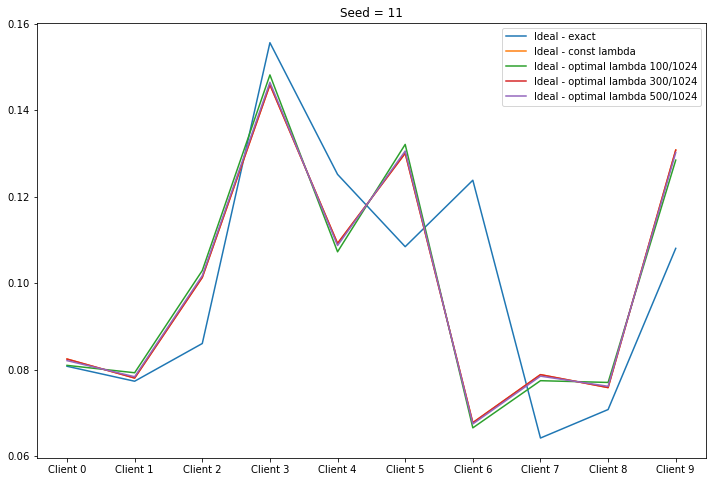

In [45]:
x = ['Client {}'.format(i) for i in range(n_clients)]
plt.figure(figsize=(12, 8))
plt.plot(x, ideal.sum(axis=0) / ideal.sum(), label='Ideal - exact')
plt.plot(x, const_lambda_SV / const_lambda_SV.sum(), label='Ideal - const lambda')
for key, value in optimal_lambda_SV.items():
    plt.plot(x, value / value.sum(), label='Ideal - optimal lambda {}/{}'.format(key, pow(2, n_clients)))
plt.legend()
plt.title('Seed = 11')
plt.show()

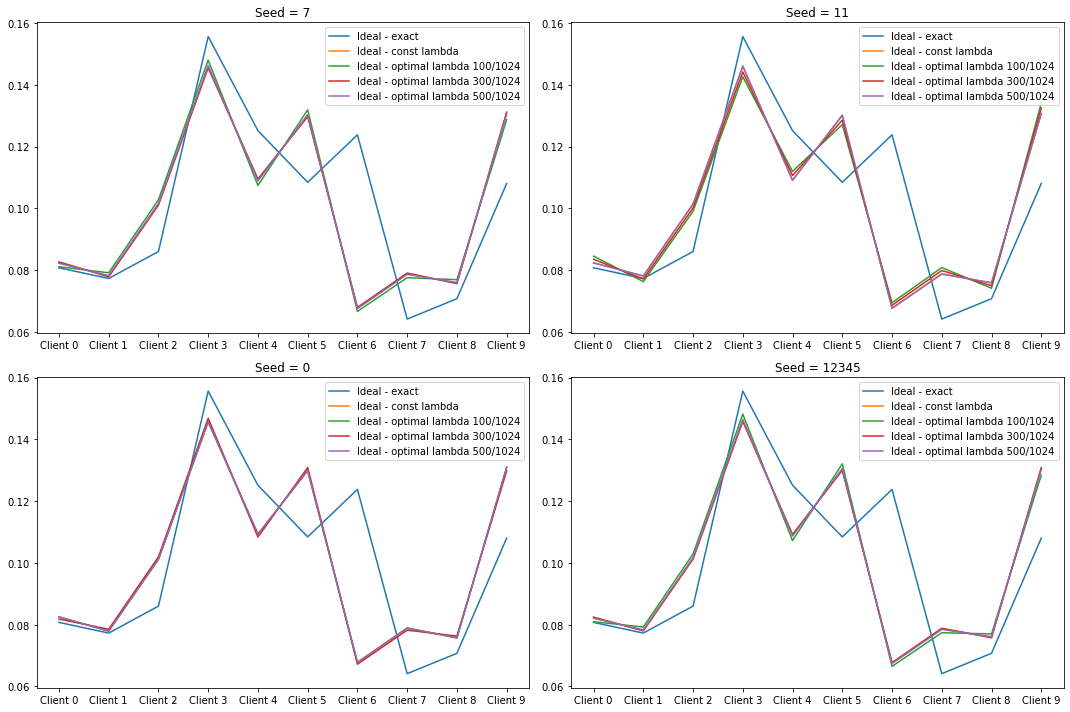

In [46]:
x = ['Client {}'.format(i) for i in range(n_clients)]
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
for index, (seed, optimal_lambda_SV) in enumerate(optimal_lambda_SV_dict.items()):
    ax[index // 2, index % 2].plot(x, ideal.sum(axis=0) / ideal.sum(), label='Ideal - exact')
    ax[index // 2, index % 2].plot(x, const_lambda_SV / const_lambda_SV.sum(), label='Ideal - const lambda')
    for key, value in optimal_lambda_SV.items():
        ax[index // 2, index % 2].plot(x, value / value.sum(), label='Ideal - optimal lambda {}/{}'.format(key, pow(2, n_clients)))
    ax[index // 2, index % 2].legend()
    ax[index // 2, index % 2].set_title('Seed = {}'.format(seed))
fig.tight_layout()
plt.show()